<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_07_Metaparameters_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

## Numerical Analysis
import numpy as np
import scipy.stats as stats

## Dataset Management
import pandas as pd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## High-Quality Figures
from IPython import display
display.set_matplotlib_formats("svg")

# Predict Residual Sugar

In [2]:
# We will use the Wine dataset and this time we want to predict residual sugar
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

data = data[data["total sulfur dioxide"] < 200]

# Normalize all features
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623


In [3]:
# Convert the data into tensors
cols2zscore = cols2zscore.drop("residual sugar")
dataT = torch.tensor(data[cols2zscore].values).float()
sugar = torch.tensor(data["residual sugar"].values).float()

print(dataT.shape)
print(sugar.shape)

# We need the labels to be tensor
sugar = sugar[:,None]
print(sugar.shape)

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


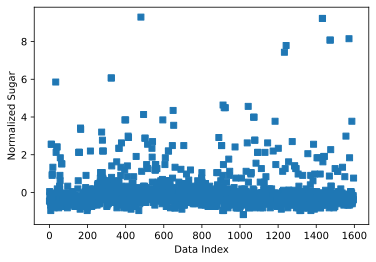

In [4]:
# Plot the sugar data
plt.plot(sugar, "s")
plt.xlabel("Data Index")
plt.ylabel("Normalized Sugar")
plt.show()
# There are many outliers, but could be genuine as well

In [5]:
# Split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, sugar, test_size=0.1)

# Convert to pytorch datasets
train_dataT = TensorDataset(train_data, train_labels)
test_dataT = TensorDataset(test_data, test_labels)

# Convert to dataloader
batchsize = 32
train_loader = DataLoader(train_dataT, batch_size=batchsize, shuffle = True, drop_last=True)
test_loader = DataLoader(test_dataT, batch_size=test_dataT.tensors[0].shape[0])

In [6]:
# Define the model class
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(11,16)

        # Define two hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # Define the output layer
        self.output = nn.Linear(32,1)

    # Forwad Pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [7]:
# Train the model
numepochs = 1000

def trainTheModel():
    # Loss function and optimizer
    lossfun = nn.MSELoss() # Regression, not classification problem
    optimizer = torch.optim.SGD(winenet.parameters(), lr = 0.01)

    # Initialize the losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    # Loop over the epochs
    for epochi in range(numepochs):

        # switch on he training mode
        winenet.train()

        # Loop over the training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from single batch
            batchLoss.append(loss.item())

            # Training Accuracy for single batch
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        # End of the batch loop
        # Average losses accross the baches
        trainLoss[epochi] = np.mean(batchLoss)

        # test the accuracy
        winenet.eval()
        # Extract X and y from dataloader
        X,y = next(iter(test_loader))
        # deactivate autograd
        with torch.no_grad():
            yHat = winenet(X)
        testLoss[epochi] = lossfun(yHat,y).item()
    # Final output
    return trainLoss, testLoss

In [8]:
# Create the model and run it
winenet = ANNwine()
trainLoss, testLoss = trainTheModel()

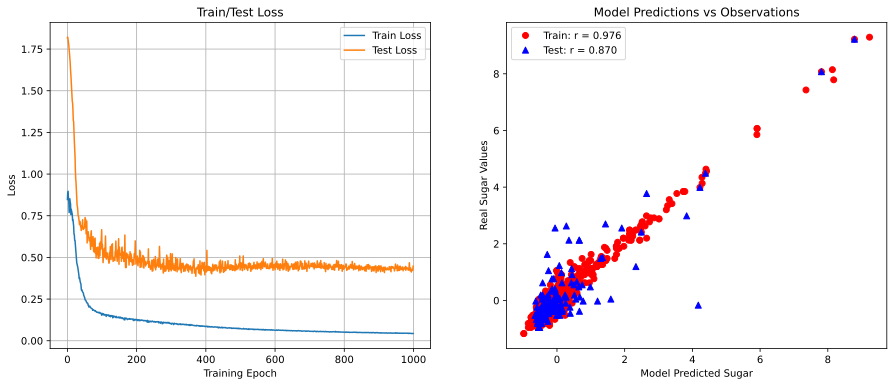

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(trainLoss, label = "Train Loss")
ax[0].plot(testLoss, label="Test Loss")
ax[0].set_title("Train/Test Loss")
ax[0].set_xlabel("Training Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid()

# Predictions vs real values
yHatTrain = winenet(train_data)
yHatTest = winenet(test_data)

ax[1].plot(yHatTrain.detach(), train_labels, "ro")
ax[1].plot(yHatTest.detach(), test_labels, "b^")
ax[1].set_xlabel("Model Predicted Sugar")
ax[1].set_ylabel("Real Sugar Values")
ax[1].set_title("Model Predictions vs Observations")

# Correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T, train_labels.T)[1,0]
corrTest = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend(["Train: r = {:.3f}".format(corrTrain), "Test: r = {:.3f}".format(corrTest)])

plt.show()

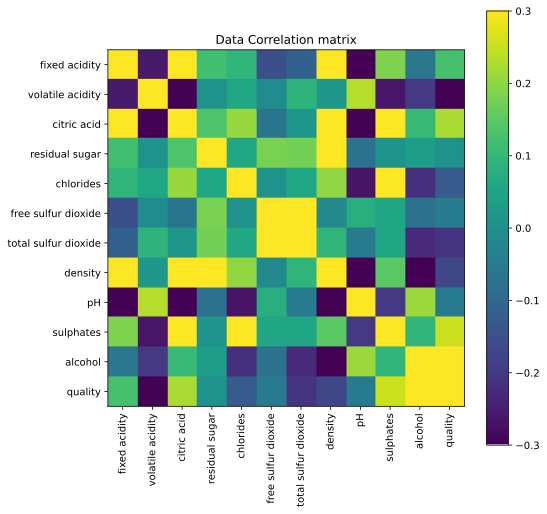

In [10]:
# Correlation Matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T), vmin=-0.3, vmax=0.3)
plt.xticks(range(len(data.keys())), labels=data.keys(), rotation=90)
plt.yticks(range(len(data.keys())), labels=data.keys())
plt.colorbar()
plt.title("Data Correlation matrix")
plt.show()

# Loss Functions in PyTorch

## Mean-Square Erroe (MSE)

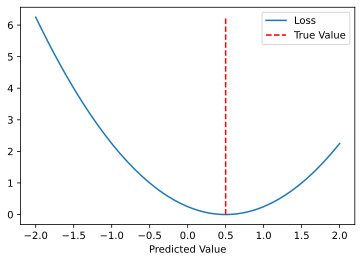

In [11]:
# Loss function instance
lossfunMSE = nn.MSELoss()

# Create predictions and real answer
yHat = torch.linspace(-2, 2, 101)
y = torch.tensor(0.5)

# Compute MSE Loss function
L = np.zeros(101)
for i,yy in enumerate(yHat):
    L[i] = lossfunMSE(yy,y)

plt.plot(yHat, L, label="Loss")
plt.plot([y,y], [0,np.max(L)], "r--",label="True Value")
plt.xlabel("Predicted Value")
plt.legend()
plt.show()
# The further we are from the true value, the larger the loss

## Binary Cross Entropy (BCE)

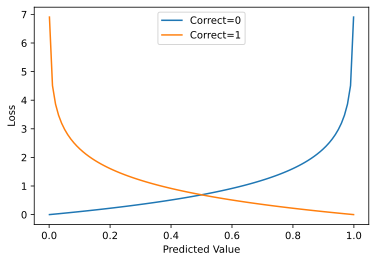

In [19]:
# Create loss function instance
lossfunBCE = nn.BCELoss()

# Create predictions and the real values
# In this case we create probabilities
yHat = torch.linspace(.001, .999, 101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

# Compute the BCE Loss function
L = np.zeros((101,2))
for i,yy in enumerate(yHat):
    L[i,0] = lossfunBCE(yy,y1) # Correct answer is zero
    L[i,1] = lossfunBCE(yy,y2) # Correct Answer is 1

plt.plot(yHat, L)
plt.xlabel("Predicted Value")
plt.ylabel("Loss")
plt.legend(["Correct=0", "Correct=1"])
plt.show()

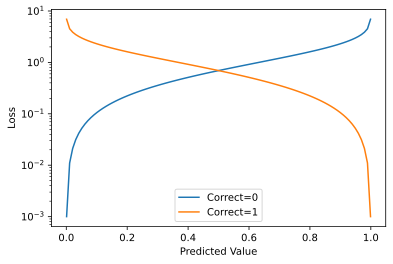

In [20]:
# Do the same in logarithmic form
plt.plot(yHat, L)
plt.xlabel("Predicted Value")
plt.ylabel("Loss")
plt.legend(["Correct=0", "Correct=1"])
plt.yscale("log")
plt.show()

In [22]:
# If we try BCE for values other than 0-1 range we get an error unless we apply sigmoid function
yHat = torch.tensor(2.)
#print(lossfunBCE(yHat, y2))

# First convert to probability using the sigmoid function
sig = nn.Sigmoid()
print(lossfunBCE(sig(yHat),y2))

tensor(0.1269)


In [24]:
# PyTorch ecommends using a function that does the work of both sigmoid and BCE at once, called BCEWithLogitsLoss()
# Using the same prblem as above
lossfunBCE = nn.BCEWithLogitsLoss()
yHat = torch.tensor(2.)
print(lossfunBCE(yHat,y2))

tensor(0.1269)


## Categorical Cross-Entropy